# Step 1: Full EDA and Optimized Feature Preparation
This notebook analyzes the training data and generated pairs, performs exploratory data analysis (EDA), and extracts features for machine learning.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

In [88]:
df = pd.read_excel('../data/train_customers.xlsx')
pairs = pd.read_csv('../data/train_pairs.csv')
print(f"Records: {len(df)}, Pairs: {len(pairs)}")

Records: 1300, Pairs: 2999


In [44]:
df.head()

,Entity ID,First Name,Last Name,Birthdate,Gender,Job,Email,Phone,Address,City,Country,ID Number,Insurance No,Marital Status,Nationality,Notes,Customer Type
0,0,Danielle,Johnson,1963-02-01,Male,Financial risk analyst,donaldgarcia@example.net,+1-219-560-0133,"79402 Peterson Drives Apt. 511 Davisstad, PA 3...",Lake Stephenville,Uzbekistan,496922,182627,Single,Micronesia,Stop peace technology officer relate.,unique
1,0,Brandon,Johnson,1963-02-01,Male,Financial risk analyst,donaldgarcia@example.net,+1-219-560-0133,"79402 Peterson Drives Apt. 511 Davisstad, PA 3...",Lake Stephenville,Uzbekistan,496922,182627,Single,Micronesia,Stop peace technology officer relate.,duplicate
2,0,Danielle,Johnson,1963-02-01,Male,Financial risk analyst,kendragalloway@example.org,664-375-2553,"79402 Peterson Drives Apt. 511 Davisstad, PA 3...",Lake Stephenville,Uzbekistan,496922,182627,Single,Micronesia,Stop peace technology officer relate.,duplicate
3,0,Chelsea,Johnson,1963-02-01,Male,Financial risk analyst,donaldgarcia@example.net,+1-219-560-0133,"79402 Peterson Drives Apt. 511 Davisstad, PA 3...",Lake Stephenville,Uzbekistan,496922,182627,Single,Micronesia,Stop peace technology officer relate.,duplicate
4,1,George,Daniel,1955-06-29,Male,"Psychologist, counselling",onelson@example.net,+1-335-503-0564,"PSC 9537, Box 6724 APO AE 32826",Juliechester,Ukraine,711878,518801,Divorced,Guyana,Young catch management sense technology.,unique


## Distribution of Customer Types

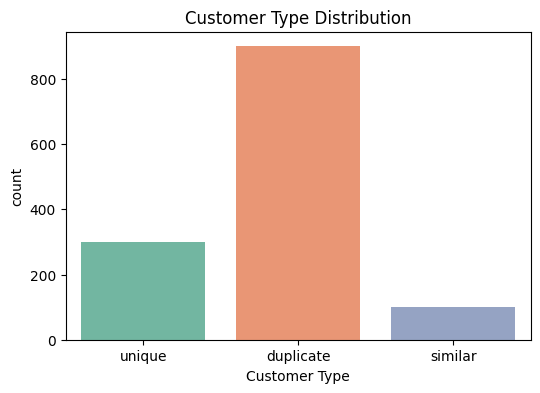

In [73]:
plt.figure(figsize=(6,4))
sns.countplot(x='Customer Type', data=df, palette='Set2')
plt.title('Customer Type Distribution')
plt.show()

In [74]:
print(f"Total pairs: {len(pairs)}")
print("Pair label distribution:")
print(pairs['is_duplicate'].value_counts())
print(pairs['is_duplicate'].value_counts(normalize=True).rename('Proportion'), "\n")

Total pairs: 2999
Pair label distribution:
is_duplicate
0    2099
1     900
Name: count, dtype: int64
is_duplicate
0    0.6999
1    0.3001
Name: Proportion, dtype: float64 



In [89]:
dupes = pairs[pairs['is_duplicate'] == 1]
nondupes = pairs[pairs['is_duplicate'] == 0]
correct_dupes = (dupes['record1_id'] == dupes['record2_id']).sum()
print(f"Valid duplicate pairs (same Entity ID): {correct_dupes} / {len(dupes)}")

bad_nondupes = (nondupes['record1_id'] == nondupes['record2_id']).sum()
print(f"Invalid negative pairs (same Entity ID): {bad_nondupes} / {len(nondupes)}")

Valid duplicate pairs (same Entity ID): 900 / 900
Invalid negative pairs (same Entity ID): 0 / 2099


## Missing Values

In [90]:
missing = df.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

## Most Common Jobs and Cities

In [91]:
print(df['Job'].value_counts().head())
print(df['City'].value_counts().head())

Job
Lecturer, further education                         20
Civil Service fast streamer                         16
Amenity horticulturist                              15
Administrator, charities/voluntary organisations    13
Lexicographer                                       12
Name: count, dtype: int64
City
Lake Peter       10
Michaelbury       8
West Robert       8
New Derekport     8
New Jamie         8
Name: count, dtype: int64


## Duplicate vs Non-Duplicate Pairs

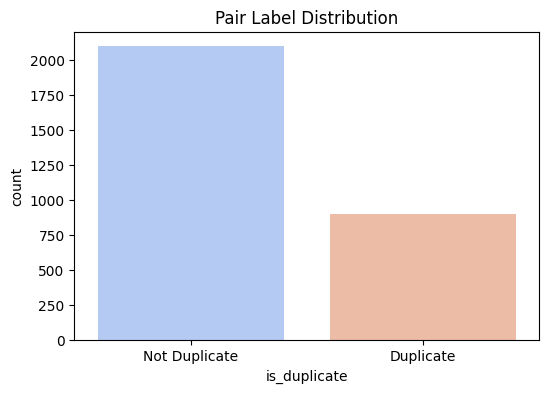

is_duplicate
0    0.6999
1    0.3001
Name: proportion, dtype: float64

In [92]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_duplicate', data=pairs, palette='coolwarm')
plt.title('Pair Label Distribution')
plt.xticks([0,1], ['Not Duplicate', 'Duplicate'])
plt.show()
pairs['is_duplicate'].value_counts(normalize=True)

## Compute Text Embeddings and TF-IDF

In [93]:
model = SentenceTransformer('all-MiniLM-L6-v2')
df['combo'] = df['First Name'] + ' ' + df['Email']
df['embedding'] = df['combo'].apply(lambda x: model.encode(x))
tfidf = TfidfVectorizer().fit(df['combo'])
tfidf_matrix = tfidf.transform(df['combo'])

## Extract Features for Each Pair

In [104]:
features = []
for row in pairs.itertuples():
    i, j = int(row.record1_index), int(row.record2_index)
    r1, r2 = df.iloc[i], df.iloc[j]

    feature = {
        #'name_sim': fuzz.token_sort_ratio(r1['First Name'], r2['First Name']),
        #'last_name_sim': fuzz.token_sort_ratio(r1['Last Name'], r2['Last Name']),
        #'email_sim': fuzz.token_sort_ratio(r1['Email'], r2['Email']),
        #'birthdate_diff': abs(pd.to_datetime(r1['Birthdate']) - pd.to_datetime(r2['Birthdate'])).days,
        'tfidf_sim': cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0],
        'embedding_sim': cosine_similarity([r1['embedding']], [r2['embedding']])[0][0],
        #'gender_match': int(r1['Gender'] == r2['Gender']),
        #'phone_match': int(r1['Phone'] == r2['Phone']),
        #'insurance_match': int(r1['Insurance No'] == r2['Insurance No']),
        'is_duplicate': row.is_duplicate
    }
    features.append(feature)


In [105]:
features_df = pd.DataFrame(features)
features_df.to_csv('../output/feature_matrix.csv', index=False)
features_df.head()

,tfidf_sim,embedding_sim,is_duplicate
0,0.574226,0.669126,1
1,0.441594,0.858730,1
2,0.521345,0.652310,1
3,0.010550,0.630386,1
4,0.601225,0.913340,1


In [84]:
leak_prone = []
for col in X.columns:
    table = pd.crosstab(X[col], y, normalize='index')
    if (table[0] == 1).all() or (table[1] == 1).all():
        leak_prone.append(col)

NameError: name 'X' is not defined


Checking potential leakage in binary features...

Feature: birthdate_diff
is_duplicate      0    1
birthdate_diff          
0               0.0  1.0
4               1.0  0.0
5               1.0  0.0
25              1.0  0.0
42              1.0  0.0
...             ...  ...
21812           1.0  0.0
21856           1.0  0.0
22000           1.0  0.0
22145           1.0  0.0
22413           1.0  0.0

[1948 rows x 2 columns]


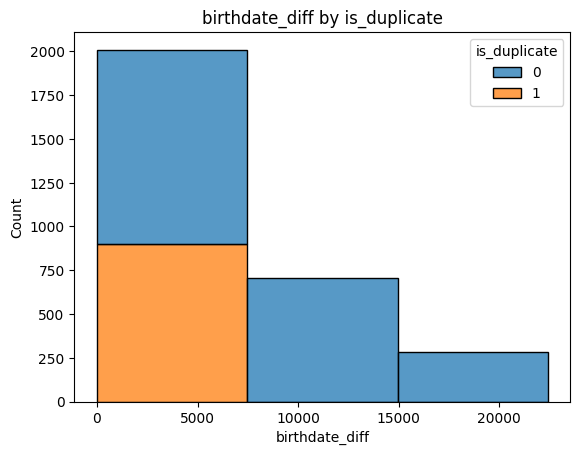


Feature: embedding_sim
is_duplicate     0    1
embedding_sim          
0.166891       1.0  0.0
0.171559       1.0  0.0
0.199833       1.0  0.0
0.202571       1.0  0.0
0.218134       1.0  0.0
...            ...  ...
1.000000       0.0  1.0
1.000000       0.0  1.0
1.000000       0.0  1.0
1.000000       0.0  1.0
1.000000       0.0  1.0

[2766 rows x 2 columns]


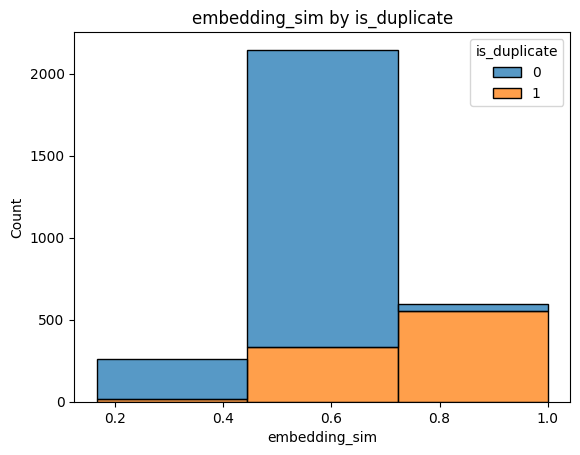


Feature: tfidf_sim
is_duplicate     0     1
tfidf_sim               
0.008542      1.00  0.00
0.008741      1.00  0.00
0.008741      0.75  0.25
0.008751      1.00  0.00
0.008766      0.50  0.50
...            ...   ...
0.665489      0.00  1.00
0.666283      0.00  1.00
1.000000      0.00  1.00
1.000000      0.00  1.00
1.000000      0.00  1.00

[2363 rows x 2 columns]


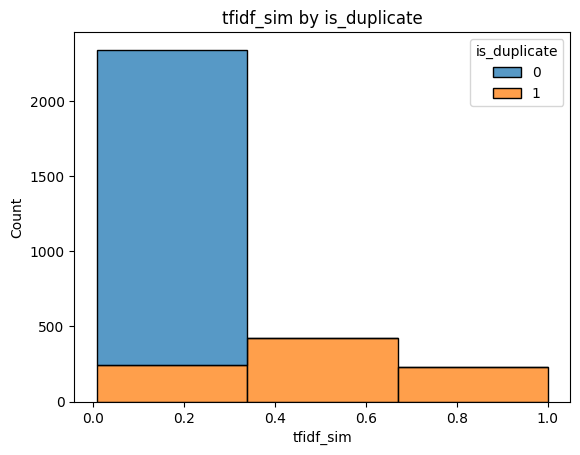

In [103]:
# Quick leakage analysis: Check if any feature perfectly separates label
print("\nChecking potential leakage in binary features...")
import seaborn as sns
from matplotlib import pyplot as plt
leak_check_cols = ['birthdate_diff', 'embedding_sim','tfidf_sim']
leak_df = pd.read_csv('../output/feature_matrix.csv')
for col in leak_check_cols:
    ct = pd.crosstab(leak_df[col], leak_df['is_duplicate'], normalize='index')
    print(f"\nFeature: {col}")
    print(ct)
    sns.histplot(data=leak_df, x=col, hue='is_duplicate', multiple='stack', bins=3)
    plt.title(f"{col} by is_duplicate")
    plt.show()

## Feature Correlation

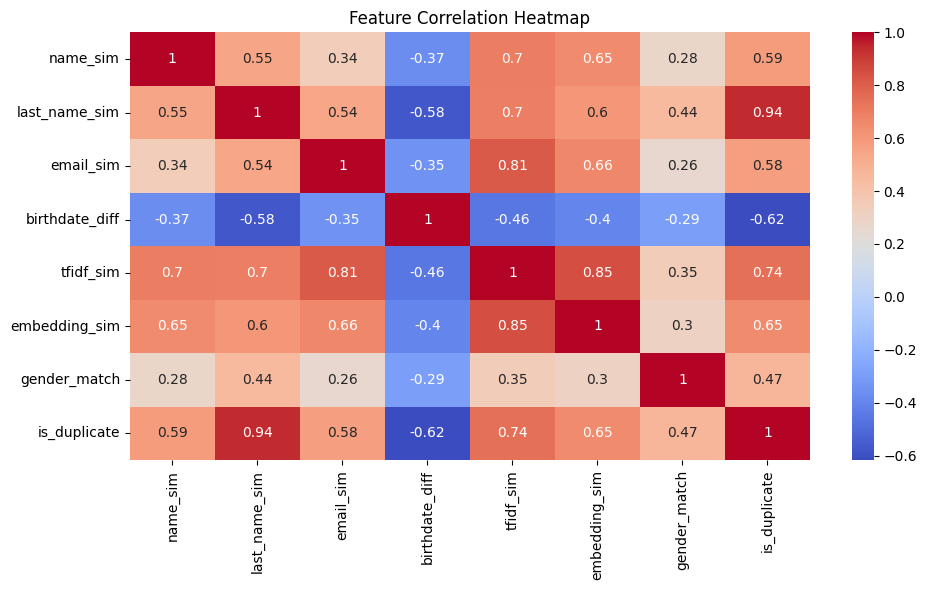

In [100]:
plt.figure(figsize=(10,6))
sns.heatmap(features_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## Feature Distributions by Label

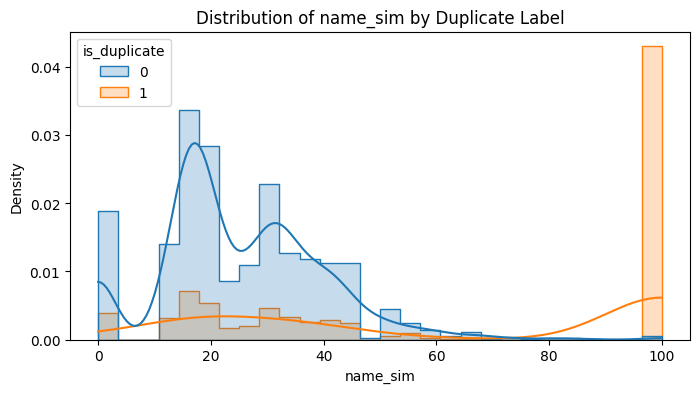

ValueError: Could not interpret value `last_name_sim` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x400 with 0 Axes>

In [67]:
for col in ['name_sim','last_name_sim', 'email_sim', 'birthdate_diff', 'tfidf_sim', 'embedding_sim','gender_match', 'phone_match', 'insurance_match']:
    plt.figure(figsize=(8,4))
    sns.histplot(data=features_df, x=col, hue='is_duplicate', kde=True, stat='density', element='step')
    plt.title(f'Distribution of {col} by Duplicate Label')
    plt.show()